# Stability Analysis of alUSD coin

In [1]:
import os, sys
import requests
import pandas as pd
import numpy as np
from datetime import timedelta as td, datetime as dt, timezone
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

# Scripts
scripts_module_path = os.path.abspath(os.path.join(os.getcwd(),'..', 'scripts'))
if scripts_module_path not in sys.path:
    sys.path.append(scripts_module_path)
from acquisition import Acquisition as Akw
from handling import getDataFrame, addReversionAndVolatility, addAverages
from viz import createBasicAnalysisPlot

In [2]:
# common keywords
basic_kwargs = dict(granularity='days')

# required for data acquisition
acquisition_kwargs = dict(**basic_kwargs,
                          datetime_from=dt.now() - td(days=523),
                          datetime_till=dt.now(),
                          downloadIfMissing=True,
                          includeOffPeg=True)
# required for the estimation of the reversion rate
reversion_kwargs = dict(**basic_kwargs,
                        windowSize=85,
                        minDataPoints=60,
                        discount_factor = 0.1,
                        sampleError=0.0001,
                        verbose=True)

## Depegging, Volatility and Reversion rate of alUSD

In [3]:
alusd = getDataFrame(whichData="cg_alusd_usd", **acquisition_kwargs)
alusd_df = addReversionAndVolatility(alusd, **reversion_kwargs)
addAverages(alusd_df, columns=["price", "rate", "sigma"], com=5, inplace=True)

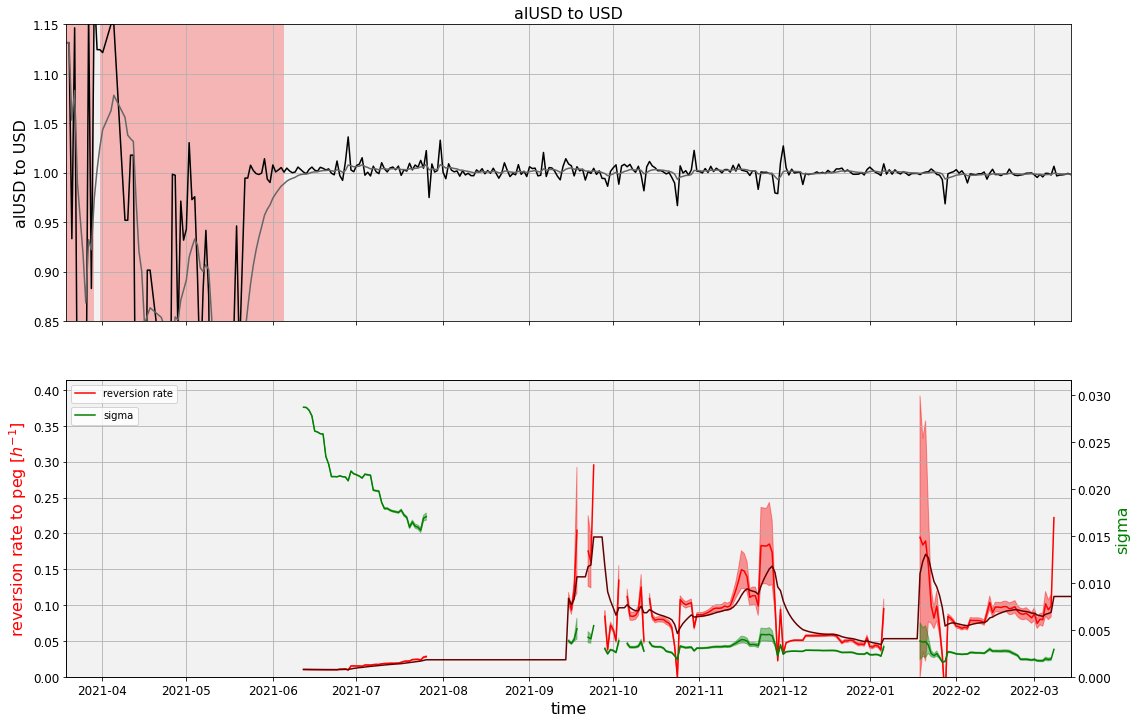

In [5]:
fig, axes, secax = createBasicAnalysisPlot(df=alusd_df, title="alUSD to USD", price_dev=0.08)
axes[0].plot(alusd_df.date, alusd_df.price_ewm, color="#666")
axes[1].set_ylim([0,alusd_df.rate.max()*(1+0.4)])
secax[1].set_ylim([0,alusd_df.sigma.max()*(1+0.1)])
axes[1].plot(alusd_df.date, alusd_df.rate_ewm, color="#600")
axes[0].set_ylim([0.85,1.15])
axes[0].fill_between(alusd_df["date"], 0.8, 1.15, 
                where=(alusd_df.price_ewm>1.01) | (alusd_df.price_ewm<0.99),
                facecolor='red',
                alpha=0.25)
plt.show()

The first figure shows the price of `Alchemix USD (alUSD)` against `USD` as recorded by coingecko. The grey line shows an exponentially weighted moving average. There is one region before summer 2021 where `alUSD` has been wildly oscillating around its peg of 1 USD. Pretty much without much of a transition period it then went to become a stable coin that actually held its peg very well. There were occasional spikes throughout the year, but well within the bounds and followed by an immediate recovery. 

The second figure shows that the volatility (`green`) reflects the wild price action in the beginning of 2021 until early summer. Since then the volatility has stayed relatively constant. The reversion rate (`red`) has also hovered around 0.1, which seems to be a healthy value.